# Image classification: French cheeses

## Import TensorFlow and other libraries

In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
# import os
import pathlib
import pickle
# import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2021-11-15 23:30:49.846930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 23:30:49.846965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [2]:
# Retrieve dataset
dataset_url = "https://github.com/seub/Cheezam/raw/main/data/cheese_photos.tar.gz"
data_dir = tf.keras.utils.get_file('cheese_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(f'The data_dir is: {data_dir}')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f'Found {image_count} jpg and jpeg images.')

The data_dir is: /home/brice/.keras/datasets/cheese_photos
Found 3619 jpg and jpeg images.


## Create a tf.keras dataset

In [3]:
batch_size = 32
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")

Found 3622 files belonging to 15 classes.
Using 3478 files for training.
Found 3622 files belonging to 15 classes.
Using 144 files for validation.
Class names: ["Bleu d'Auvergne", 'Brie de Meaux', 'Brie de Melun', 'Camembert de Normandie', 'Cantal', 'Comte', 'Emmenthal de Savoie', "Fourme d'Ambert", 'Fourme de Montbrison', 'Mimolette', 'Morbier', 'Ossau-Iraty', 'Rocamadour', 'Roquefort', 'Saint-Nectaire']


2021-11-15 23:30:51.120975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-15 23:30:51.120998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-15 23:30:51.121016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brice-XPS15): /proc/driver/nvidia/version does not exist
2021-11-15 23:30:51.121282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configure the dataset for performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [5]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.1, fill_mode='constant', input_shape=input_shape),
    layers.RandomZoom(0.1, fill_mode='constant'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    #layers.RandomFlip("horizontal")
  ])

## Visualize data sample

2021-11-15 23:30:51.489213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


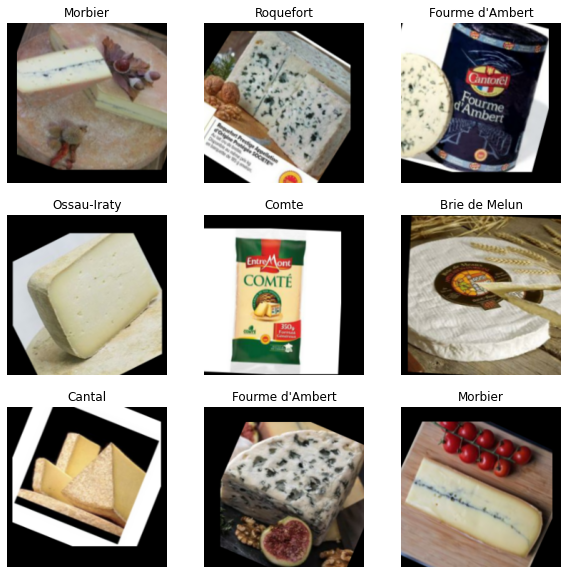

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    img_aug = data_augmentation(np.expand_dims(img, axis=0))[0]
    plt.imshow(img_aug.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Import MobileV2 model from Keras

In [7]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

model_func = model_dictionary['MobileNetV2']
base_model = model_func(include_top=False, pooling='avg', input_shape=input_shape, weights = 'imagenet')
base_model.trainable = False
base_model.summary()

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
#print(model_dictionary.keys())
model_func = model_dictionary['MobileNetV2']
print(input_shape)
base_model = model_func(include_top=False, pooling='avg', input_shape=input_shape, weights = 'imagenet')
base_model.trainable = False
print(f"Pre-trained MobileV2 model imported from Keras.")
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes))
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print(f"Added two dense layers to model.")
model.summary()

dict_keys(['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception'])
(224, 224, 3)
Pre-trained MobileV2 model imported from Keras.
Added two dense layers to model.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_2 (Dense)              (None, 15)

In [ ]:
def update_history(reset, history, model_path, epochs):
  model_path.mkdir(parents=False, exist_ok=True)
  history_path = model_path / 'training_history'
  if reset or (not history_path.is_file()):
    training_history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[], 'epochs':0}
  else:
    training_history = pickle.load(open(history_path, 'rb'))
  training_history['acc'] += history.history['accuracy']
  training_history['val_acc'] += history.history['val_accuracy']
  training_history['loss'] += history.history['loss']
  training_history['val_loss'] += history.history['val_loss']
  training_history['epochs'] += epochs
  with open(history_path, 'wb') as file_pi:
    pickle.dump(training_history, file_pi)
  return training_history

In [ ]:
epochs = 1
model_path = pathlib.Path.home() / '.keras/models/MobileV2'
reset = True
if reset==False:
  assert model_path.is_dir()

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
training_history = update_history(reset=reset, history=history, model_path=model_path, epochs=epochs)

## Visualize training results

In [ ]:
def visualize_training(training_history):
    epochs_range = range(1, 1+training_history['epochs'])

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_history['acc'], label='Training Accuracy')
    plt.plot(epochs_range, training_history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_history['loss'], label='Training Loss')
    plt.plot(epochs_range, training_history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig("training_history.png")
    plt.show()
visualize_training(training_history)

## Predict on new data

In [ ]:
from IPython.display import display

def cheezam(filepath : str):
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display( PIL.Image.open(filepath).resize((img_height, img_width)) )

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

In [ ]:
import random
test_dir = pathlib.Path('data/sample_dataset')
test_paths_total = list(test_dir.glob('*/*.jpg'))
nb_test, nb_test_total = 10, len(test_paths_total)
test_paths = random.sample(test_paths_total, nb_test)
print(len(test_paths))
for test_path in test_paths:
    cheezam(test_path)

In [ ]:
photos_brice_dir = pathlib.Path('data/photos_brice')
photos_brice_paths = list(photos_brice_dir.glob('*.jpg'))
for photo in photos_brice_paths:
    cheezam(photo)

In [ ]:
visualize_training(training_history1)